# Cделать систему рекомендации друзей в социальной сети, которая для данного пользователя выдает список пользователей, с кем пользователь вероятней всего подружится.

### Переформулировать продуктовую задачу в Data Science задачу

На мой взгляд, эта задача уже сформулирована как DS задача. Необходимо вычислить всех возможных кандидатов в друзья, определить признаки, сопутствующие кандидатам, подобрать алгоритм и метрику и, используя эти данные, определить наиболее релевантных кандидатов в друзья - т.е. сделать систему рекомендации друзей в социальной сети, которая для данного пользователя выдает список пользователей, с кем пользователь вероятней всего подружится. Провести тесты, посчитать метрику - например, сколько пользователей из рекомендованных пользователь добавил в друзья, сколько отклонил или проигнорировал. Сделать выводы.  
А вот продуктовая метрика как раз другая: увеличилась ли вовлеченность пользователя в соц. сеть? Стал ли он больше проводить времени в ней? Стал больше делится контентом, ставить лайков, писать комментариев, больше общаться, тем самым увеличивая вовлеченность других пользователей? Если количество знакомых в сети увеличивает активность пользователей, значит необходимо их всех поскорее подружить. А сделать это можно с помощью эффективной рекомендательной системы.

### Сделайте два варианта работы алгоритма:
* через эвристику, не требующую машинного обучения
* через любой близкий вам вариант машинного обучения – обучение с учителем, рекомендательные системы, итд.
* эвристика будет вашим бейзлайн-алгоритмом. Докажите, что ваш ML алгоритм лучше решает поставленную задачу.

In [395]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from tqdm import tqdm_notebook as tqdm
import math
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from pylab import rcParams
rcParams['figure.figsize'] = 12, 6
from collections import Counter
from scipy import sparse

In [2]:
df = pd.read_table('test_vk/friends_dataset/friends_dataset', names=['uid1', 'uid2', 'time', 'intensity'], sep=',')

Дан анонимизированный датасет пользователей, где для каждого пользователя указан список текущих друзей пользователя. Для каждых двух пользователей известно, как давно они подружились и насколько активно взаимодействуют в соц. сети, обе величины измеряются в некоторых абстрактных величинах.

In [3]:
df.head()

,uid1,uid2,time,intensity
0,4052919,1559975,264.475747,0.000000
1,9245023,7458626,265.061965,0.000505
2,7067801,11205937,264.449128,0.000067
3,3727103,6167658,259.803427,0.035294
4,14887121,10181839,263.830863,0.181074


In [4]:
df['uid1'].unique().shape, df['uid2'].unique().shape

((37342,), (43582,))

Количество уникальных пользователей в колонках не одинаково  
Влзможно, датасет содержит список не друзей, а подписок, которые могут быть невзаимными  
Попробую оставить информацию только о взаимых подписках.

In [5]:
df1 = df.copy()
df1 = df1.rename(columns={'uid1': 'uid2', 'uid2': 'uid1'})
data = pd.merge(df, df1, how='inner', on=['uid1', 'uid2'], suffixes=['_1', '_2'])

In [6]:
data.head()

,uid1,uid2,time_1,intensity_1,time_2,intensity_2
0,4052919,1559975,264.475747,0.000000,264.475747,1.355908e-10
1,9245023,7458626,265.061965,0.000505,265.061965,9.499985e-04
2,7067801,11205937,264.449128,0.000067,264.449128,7.376613e-07
3,3727103,6167658,259.803427,0.035294,259.803427,7.930687e-01
4,14887121,10181839,263.830863,0.181074,263.830863,9.043410e-10


In [7]:
data['uid1'].unique().shape, data['uid2'].unique().shape

((37014,), (37014,))

Теперь данные содержат только информацию о взаимых подписках

Представим граф социальных связей с помощью разреженной матрицы  
В дальнейшем с ее помощью можно будет быстро вычислять различные параметры сети, такие как количество общих друзей.  
И остальные данные (время, интенсивность общения) можно представить в виде разреженных матриц.

In [8]:
size = data['uid1'].unique().shape[0] 
uids = data['uid1'].unique()
uid_values = dict(zip(uids, range(0, size)))
uid_keys = dict(zip(range(0, size), uids))
rows = [uid_values[i] for i in data['uid1'].values]
cols = [uid_values[i] for i in data['uid2'].values]

In [9]:
friends_data = [1 for i in range(len(rows))]
friends_matrix = sparse.csr_matrix((friends_data, (rows, cols)), shape=(size, size))

In [10]:
friends_matrix

<37014x37014 sparse matrix of type '<class 'numpy.int64'>'
	with 978524 stored elements in Compressed Sparse Row format>

Проверим полученную матрицу: посчитаем количество общих друзей для двух пользователей с помощью матрицы и вручную.

In [11]:
test_user = 4052919
test_friend = 1559975
test_user_friends = set(df.loc[df['uid1'] == test_user, 'uid2'].values)

common_friends = []
for fr in tqdm(np.array(df.loc[(df['uid1'] == test_friend), 'uid2'].values)):
    if fr in test_user_friends:
        common_friends.append(fr)
        
matrix_common_friends = []
for fr in tqdm(friends_matrix[uid_values[test_user]].multiply(friends_matrix[uid_values[test_friend]]).nonzero()[1]):
    matrix_common_friends.append(uid_keys[fr])
            
sorted(common_friends) == sorted(matrix_common_friends), sorted(common_friends), sorted(matrix_common_friends)

(True,
 [10360792, 12130661, 14545447, 15547815],
 [10360792, 12130661, 14545447, 15547815])

Ok

Создадим матрицу, содержащую информацию о количестве общих друзей у между пользователями

In [12]:
common_friends_matrix = friends_matrix * friends_matrix

Ну и проверим по уже известным нам двум пользователям

In [13]:
common_friends_matrix[uid_values[test_user], uid_values[test_friend]], common_friends_matrix[uid_values[test_user], uid_values[test_friend]] == len(common_friends) == len(matrix_common_friends)

(4, True)

Создадим матрицы, содержащие информацию об интенсивности и продолжительности взаимодействия пользователей.  
Это будут также симметричные матрицы, т.к. я сразу посчитаю среднее время дружбы между двуми пользователями и сумму интенсивности их общения.

In [14]:
data['mean_time'] = (data['time_1'] + data['time_2']) / 2
data['intensity_sum'] = (data['intensity_1'] + data['intensity_2']) / 2

In [15]:
time_average_matrix = sparse.csr_matrix((data['mean_time'].values, (rows, cols)), shape=(size, size))
intensity_sum_matrix = sparse.csr_matrix((data['intensity_sum'].values, (rows, cols)), shape=(size, size))

In [16]:
time_average_matrix[uid_values[test_user], uid_values[test_friend]], time_average_matrix[uid_values[test_user], uid_values[test_friend]] == data[(data['uid1'] == test_user) & (data['uid2'] == test_friend)]['mean_time'].values[0]

(264.47574727755557, True)

In [17]:
intensity_sum_matrix[uid_values[test_user], uid_values[test_friend]], intensity_sum_matrix[uid_values[test_user], uid_values[test_friend]] == data[(data['uid1'] == test_user) & (data['uid2'] == test_friend)]['intensity_sum'].values[0]

(6.779540321224358e-11, True)

Можно приступать к заданию.

### Через эвристику, не требующую машинного обучения

Первая эвистика, что приходит в голову - это количество общих друзей.  
Т.е. просто посмотреть друзей друзей, определить среди них тех, с кем общих друзей больше, и отранжировать их.   
Однако, такой подход не учитывает общее количество друзей у общего знакомого. Некоторые могут добавлять к себе много людей (локальные и глобальные знаменитости, бизнесмены и интернет-предприниматели, просто люди, стремящиеся подружиться с как можно большим количеством людей).  
Тут на помощь приходит коэффициент Адамик/Адара - взвешенная сумма общих друзей. Вес в этой сумме зависит от числа друзей общего друга. Чем меньше друзей у общего друга, тем больший вклад он дает в результирующую сумму. 

Попробуем использовать коэффициент Адамик/Адара в качестве бейзлайна в данном решении. 

Ок, создадим матрицу, содержащую значения коэффициента Адамик/Адара.  
Для этого потребуется:  
1) посчитать вектор, элементы которого содержат количество друзей каждого пользователя;  
2) диагональная матрица, диагональ которой состоит из элементов вектора, подсчитанного в пункте 1;  
3) для конкретного пользователя U создать диагональную матрицу, диагональ которой состоит из элементов строки матрицы связи пользователя U;  
4) перемножая матрицу связи на матрицу из пункта 3, получаем матрицу, в которой (i, j) элемент, равный 1, озаначает, что у пользователя U есть общий друг с пользователем i, и это пользователь j;    
5) перемножая матрицу из пункта 4 с матрицей из пункта 2, получаем матрицу, в которой ненулевой (i, j) элемент X означает, что у пользователя U есть общий друг с пользователем i, это пользователь j, у которого всего X друзей;  
6) остается посчитать 1 / log(x) для ненулевых элементов, построчно проссумировать - получается вектор коэффициентов Адамик/Адара для пользователя (элементов, равных 1 также не будет, т.к. не может быть общих друзей с пользователем, у которого один друг).

In [18]:
friends_count = [friends_matrix[i].sum() for i in range(size)]

In [19]:
friends_count_matrix = sparse.csr_matrix((friends_count, ([i for i in range(size)], [i for i in range(size)])),
                                         shape=(size, size))

In [20]:
def get_adamic_matrix(uid):
    user_links = friends_matrix[uid_values[uid]].toarray().reshape(-1, )
    user_links_matrix = sparse.csr_matrix((user_links, ([i for i in range(size)], [i for i in range(size)])),
                                          shape=(size, size))
    adamic_matrix = friends_matrix * user_links_matrix * friends_count_matrix
    return adamic_matrix.asfptype()

In [21]:
def get_top_friends(uid):
    adamic_matrix = get_adamic_matrix(uid)
    length = adamic_matrix.nonzero()[0].shape[0]
    j = adamic_matrix.nonzero()[0]
    k = adamic_matrix.nonzero()[1]
    for i in range(length):
            adamic_matrix[j[i], k[i]] = (1 / np.log(adamic_matrix[j[i], k[i]])) # посчитаем логарифм ненулевых эл.
    adamic_vector = np.array([adamic_matrix[i].sum() for i in range(size)]) # и проссумируем соотв. п.6
    adamic_vector[uid_values[uid]] = 0 #удалим из списка самого пользователя
    adamic_vector[friends_matrix[uid_values[uid]].nonzero()[1]] = 0 #и всех его друзей
    
    return Counter(dict(zip([uid_keys[i] for i in adamic_vector.nonzero()[0]], 
                            adamic_vector[adamic_vector.nonzero()[0]]))).most_common(20)

In [24]:
%%time
get_top_friends(test_user)

CPU times: user 7.21 s, sys: 6.72 ms, total: 7.21 s
Wall time: 7.26 s


[(9157706, 5.939734197324806),
 (6718597, 5.246150634402495),
 (86527, 4.19298554880531),
 (12514760, 4.172198860190034),
 (10181839, 4.146260448651293),
 (6941391, 3.6409698345725325),
 (1725125, 3.458857676826746),
 (3697025, 3.3304211234879637),
 (8207204, 3.303861381159185),
 (8747060, 3.278384754568695),
 (8408875, 3.107934239304233),
 (2720992, 3.0905412125530662),
 (903943, 3.0539190333029884),
 (6577559, 3.046727665699664),
 (11062028, 2.944541540996986),
 (10408761, 2.8665337964776354),
 (6781049, 2.8171583490292105),
 (7976454, 2.814019744972192),
 (5967021, 2.759135086286418),
 (14388511, 2.677113288687988)]

In [28]:
# из-за бага с %%time в ipython 7.4 приходится проделывать это дважды, анаконда что-то тоже не хочет апдейтиться
top_adamic_friends = get_top_friends(test_user)

В общем-то неплохо, за относительно небольшое время считаем топ-20 потенциальных связей для пользователя с 102 друзьями. 

Но хотелсь бы еще использовать информацию об интенсивности и времени общении.  
Для этого немного изменим функцию `get_top_friends`, складывая результат перемножения матрицы коэффициентов Адамик/Адара с вектором интенсивности пользователя и полной матрицей интенсивностей, и результат перемножения матрицы коэффициентов Адамик/Адара с вектором времени пользователя и полной матрицей времен.   
Получится матрица, элемент (i, j) которой равен:
$$ Aij*Ii*Ti + Aij*Ij*Tj, $$  
где Aij - коэффициент Адамик/Адара общего для двух кандидатов пользователя, T - время общения каждого кадидата с общим другом, I - интенсивность.  
Таким образом удается учитывать время и интенсивность общения обоих кандидатов с общим другом.

In [29]:
def get_top_friends(uid):
    adamic_matrix = get_adamic_matrix(uid)
    length = adamic_matrix.nonzero()[0].shape[0]
    j = adamic_matrix.nonzero()[0]
    k = adamic_matrix.nonzero()[1]
    for i in range(length):
            adamic_matrix[j[i], k[i]] = (1 / np.log(adamic_matrix[j[i], k[i]]))
    adamic_matrix = adamic_matrix.multiply(intensity_sum_matrix).multiply(time_average_matrix) + adamic_matrix.multiply(intensity_sum_matrix[uid_values[uid]]).multiply(time_average_matrix[uid_values[uid]])
    adamic_vector = np.array([adamic_matrix[i].sum() for i in range(size)])
    adamic_vector[uid_values[uid]] = 0 
    adamic_vector[friends_matrix[uid_values[uid]].nonzero()[1]] = 0
    
    return Counter(dict(zip([uid_keys[i] for i in adamic_vector.nonzero()[0]], adamic_vector[adamic_vector.nonzero()[0]]))).most_common(20)

In [30]:
%%time
get_top_friends(test_user)

CPU times: user 7.53 s, sys: 3.28 ms, total: 7.53 s
Wall time: 7.55 s


[(9157706, 2195.4283545556827),
 (6718597, 1755.2896525584413),
 (86527, 1479.5027081008773),
 (12514760, 1421.1238138188355),
 (10408761, 1343.5861193490393),
 (1725125, 1302.5140339551087),
 (16362876, 1269.8683797579683),
 (6577559, 1245.459070676134),
 (13844609, 1179.366933933531),
 (903943, 1151.6972156519273),
 (12167488, 1136.898241982105),
 (6781049, 1129.978906162192),
 (8207204, 1067.9080019823857),
 (8408875, 1052.9184654103603),
 (2720992, 1036.1953440536286),
 (6316803, 1010.0921837208745),
 (10181839, 998.8500152044073),
 (5967021, 984.3845910337145),
 (6941391, 951.0874683563195),
 (3027020, 874.776619262041)]

In [31]:
top_friends = get_top_friends(test_user)

Сравним результаты работы старой и нвой версии `get_top_friends`

In [33]:
list(zip(top_adamic_friends, top_friends))

[((9157706, 5.939734197324806), (9157706, 2195.4283545556827)),
 ((6718597, 5.246150634402495), (6718597, 1755.2896525584413)),
 ((86527, 4.19298554880531), (86527, 1479.5027081008773)),
 ((12514760, 4.172198860190034), (12514760, 1421.1238138188355)),
 ((10181839, 4.146260448651293), (10408761, 1343.5861193490393)),
 ((6941391, 3.6409698345725325), (1725125, 1302.5140339551087)),
 ((1725125, 3.458857676826746), (16362876, 1269.8683797579683)),
 ((3697025, 3.3304211234879637), (6577559, 1245.459070676134)),
 ((8207204, 3.303861381159185), (13844609, 1179.366933933531)),
 ((8747060, 3.278384754568695), (903943, 1151.6972156519273)),
 ((8408875, 3.107934239304233), (12167488, 1136.898241982105)),
 ((2720992, 3.0905412125530662), (6781049, 1129.978906162192)),
 ((903943, 3.0539190333029884), (8207204, 1067.9080019823857)),
 ((6577559, 3.046727665699664), (8408875, 1052.9184654103603)),
 ((11062028, 2.944541540996986), (2720992, 1036.1953440536286)),
 ((10408761, 2.8665337964776354), (6316

Видно, что некоторые пользователи поднялись в рейтинге, некоторые упали.  
Свой вклад вносят интенсивность и время общения. Интенсивность влияет посильнее, т.к. время практически у всех не сильно отличается. Интенсивность же разнится довольно сильно.

In [34]:
data['mean_time'].mean(), data['mean_time'].std(), data['mean_time'].median(), data['mean_time'].quantile(.75) - data['mean_time'].quantile(.25)

(263.1547418587259, 8.08910035335979, 261.41521580964115, 7.28768411306487)

In [35]:
data['intensity_sum'].mean(), data['intensity_sum'].std(), data['intensity_sum'].median(), data['intensity_sum'].quantile(.75) - data['intensity_sum'].quantile(.25)

(0.4296335634759163,
 0.5453227578096856,
 0.2347167280053749,
 0.5677317041290184)

Еще до этого я думал обойтись без разреженных матриц и просто собирал данные по датафрейму.  
Продемонстрирую результат этой работы для сравнения.

In [36]:
%%time
users = pd.DataFrame({'uid': data['uid1'].unique()})
users['friends_count'] = users['uid'].apply(lambda x: data.loc[data['uid1'] == x].shape[0])
users['adamic'] = users['friends_count'].apply(lambda x: 1 / math.log(x) if x > 1 else -1)

CPU times: user 60 s, sys: 151 ms, total: 1min
Wall time: 1min


In [37]:
users = pd.DataFrame({'uid': data['uid1'].unique()})
users['friends_count'] = users['uid'].apply(lambda x: data.loc[data['uid1'] == x].shape[0])
users['adamic'] = users['friends_count'].apply(lambda x: 1 / math.log(x) if x > 1 else -1)

In [38]:
def get_pair_intensity(uid1, uid2):
    return data[(data['uid1'] == uid1) & (data['uid2'] == uid2)]['intensity_sum'].values[0]

In [39]:
def get_pair_time(uid1, uid2):
    return data[(data['uid1'] == uid1) & (data['uid2'] == uid2)]['mean_time'].values[0]

In [40]:
def get_top_friends_old(uid):
    friends = np.array(data.loc[data['uid1'] == uid, 'uid2'].values) # олучили список друзей пользователя
    friends_2 = Counter()
    for friend in tqdm(friends): # для каждого друга получим список его друзей, исключая самого пользователя и его друзей
        for fr2 in np.array(data.loc[(data['uid1'] == friend) & (data['uid2'] != uid), 'uid2'].values):
            if fr2 not in friends:
                if fr2 not in friends_2:
                    friends_2[fr2] = users[users['uid'] == friend]['adamic'].values[0] * (get_pair_intensity(uid, friend) * get_pair_time(uid, friend) + get_pair_intensity(fr2, friend) * get_pair_time(fr2, friend))
                else:
                    friends_2[fr2] += users[users['uid'] == friend]['adamic'].values[0] * (get_pair_intensity(uid, friend) * get_pair_time(uid, friend) + get_pair_intensity(fr2, friend) * get_pair_time(fr2, friend))
    return friends_2

In [43]:
top_friends_old = get_top_friends_old(test_user)

In [44]:
list(zip(top_friends_old.most_common(20), top_friends))

[((9157706, 2195.4283545556827), (9157706, 2195.4283545556827)),
 ((6718597, 1755.2896525584415), (6718597, 1755.2896525584413)),
 ((86527, 1479.5027081008775), (86527, 1479.5027081008773)),
 ((12514760, 1421.1238138188353), (12514760, 1421.1238138188355)),
 ((10408761, 1343.5861193490389), (10408761, 1343.5861193490393)),
 ((1725125, 1302.5140339551087), (1725125, 1302.5140339551087)),
 ((16362876, 1269.8683797579683), (16362876, 1269.8683797579683)),
 ((6577559, 1245.459070676134), (6577559, 1245.459070676134)),
 ((13844609, 1179.3669339335313), (13844609, 1179.366933933531)),
 ((903943, 1151.6972156519275), (903943, 1151.6972156519273)),
 ((12167488, 1136.8982419821048), (12167488, 1136.898241982105)),
 ((6781049, 1129.978906162192), (6781049, 1129.978906162192)),
 ((8207204, 1067.9080019823855), (8207204, 1067.9080019823857)),
 ((8408875, 1052.9184654103608), (8408875, 1052.9184654103603)),
 ((2720992, 1036.1953440536286), (2720992, 1036.1953440536286)),
 ((6316803, 1010.0921837208

Как видно, результаты идентчные, значит, с матрицами все в порядке.

In [50]:
np.array(top_friends_old.most_common(20)).transpose()[1] / np.array(top_friends).transpose()[1]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

Но есть большая разница во времени работы: даже с учетом предварительно подсчитанных коэффициентов Адамик/Адара (что заняло минуту), работа с таблицами заняла около 2 минут! Меня это совсем не устраивало.  
Для того же пользователя работа с матрицей заняла в районе 8-10 секунд, учитывая предварительный рассчет дополнительных матриц. Т.е. удалось добиться ускорения более чем в 10 раз.

### Через любой близкий вам вариант машинного обучения

Сначала определимся с признаками:  
1) число общих друзей;  
2) коэффициент Жаккара - отношение числа общих друзей двух пользователей к числу всех друзей (кроме общих);  
3) уже знакомый коэффициент Адамик/Адара;  
4) коэффициент, использованный в предыдущем решении;  
5) сами зачения интенсивности и времени общения;  
6) можно попробовать еще различные комбинации признаков.

Для начала хватит, будем пробовать

В первую очередь протестирую как работает KMeans. Сравню результаты работы данного алгоритма на тестовом пользователе с решением, приведенным в предыдущей части, но возьму упрощенные признаки:  
 - для всех потенциальных друзей просто посчитаю сумму интенсивностей общения пользователя и кандидата с общим другом;   
 - и просуммирую среднее время, которое пользователь и кандидат общаются с общим другом.  

In [62]:
def get_test_data(uid):
    user_links = friends_matrix[uid_values[uid]].toarray().reshape(-1, )
    user_links_matrix = sparse.csr_matrix((user_links, ([i for i in range(size)], [i for i in range(size)])),
                                          shape=(size, size))
    user_links_matrix = friends_matrix * user_links_matrix
    
    # подсчитаем суммарную интенсивность
    user_matrix = user_links_matrix.multiply(intensity_sum_matrix) + user_links_matrix.multiply(intensity_sum_matrix[uid_values[uid]])
    user_intensity_vector = np.array([user_matrix[i].sum() for i in range(size)])
    
    # подсчитаем суммарное время
    user_matrix = user_links_matrix.multiply(time_average_matrix) + user_links_matrix.multiply(time_average_matrix[uid_values[uid]])
    user_time_vector = np.array([user_matrix[i].sum() for i in range(size)])
        
    user_intensity_vector[uid_values[uid]] = 0 
    user_intensity_vector[friends_matrix[uid_values[uid]].nonzero()[1]] = 0
    user_time_vector[uid_values[uid]] = 0 
    user_time_vector[friends_matrix[uid_values[uid]].nonzero()[1]] = 0
    
    return pd.DataFrame({'uid': [uid_keys[i] for i in user_intensity_vector.nonzero()[0]], 'time': user_time_vector[user_time_vector.nonzero()[0]], 'intensity': user_intensity_vector[user_intensity_vector.nonzero()[0]]})

In [67]:
%%time
test_df = get_test_data(test_user)

CPU times: user 13 s, sys: 0 ns, total: 13 s
Wall time: 13 s


In [68]:
test_df = get_test_data(test_user)

In [69]:
test_df.head()

,uid,time,intensity
0,9245023,1107.119761,1.532603
1,3727103,518.396594,1.790787
2,11213187,540.493117,0.001085
3,15379343,1095.348378,1.249662
4,3418036,539.463411,0.013368


In [70]:
test_df.shape

(4342, 3)

Получили датафрейм с id кандидатов в друзья и данными по времени и интесивности общения с общими друзьями.  
Посмотрим как лежат точки на графике.  

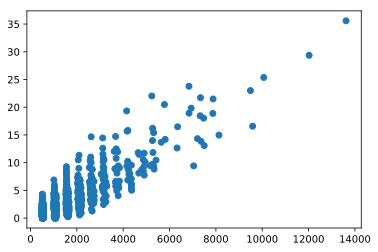

In [129]:
plt.scatter(x=test_df['time'], y=test_df['intensity'])
plt.show()

Хорошо видны скопления пользователей в левой части и небольшая группа подходящих кандидатов в правой. Потенциальные кластеры видно невооруженным взглядом.  
Подадим данные на вход алгоритму KMeans, пусть кластеров будет 10.

In [109]:
from sklearn.cluster import KMeans

In [313]:
kmeans = KMeans(n_clusters=10)

In [111]:
kmeans.fit(test_df[['time', 'intensity']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

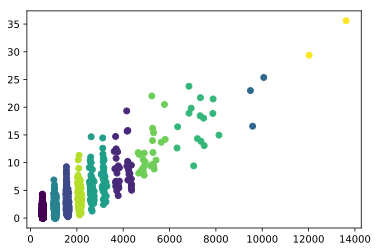

In [112]:
plt.scatter(x=test_df['time'], y=test_df['intensity'], c=kmeans.labels_)
plt.show()

Хорошо выделяются 5 немногочисленных кластера, с самыми высокими значениями времени и интенсивности.  
Именно этих пользователей и можно рекомендовать, причем в порядке увеличения размера кластеров. В каком порядке рекомендовать внутри кластера уже особой роли не играет, т.к. по определению объекты внутри кластера схожи.  
Можно увеличить количество кластеров, и тогда эти маленькие кластеры будут делиться на еще меньшие, т.к. видно, что у них не самая высокая плотность. Таким образом можно поднимать в топ рекомендаций более подходящих кандидатов.

In [119]:
pd.Series(kmeans.labels_).value_counts()

0    3034
4     723
2     257
8     126
5     120
1      38
7      24
6      15
3       3
9       2
dtype: int64

In [121]:
labels = np.array([], dtype=int)
for i in [9, 3, 6]:
    labels = np.append(labels, np.argwhere(kmeans.labels_ == i).reshape(1, -1)[0])

In [122]:
labels

array([ 886, 1716,  562, 2149, 4135,   73,  124,  466,  499,  862,  929,
       1006, 1106, 1651, 1860, 1984, 2019, 2500, 2605, 4020])

In [123]:
indexes = []
for i in labels:
    indexes.append(int(test_df['uid'].values[i]))

In [124]:
list(zip(indexes, np.array(top_friends, dtype=int).transpose()[0]))

[(6718597, 9157706),
 (9157706, 6718597),
 (86527, 86527),
 (12514760, 12514760),
 (10181839, 10408761),
 (8747060, 1725125),
 (7976454, 16362876),
 (7274553, 6577559),
 (6577559, 13844609),
 (3697025, 903943),
 (1725125, 12167488),
 (10408761, 6781049),
 (6781049, 8207204),
 (8207204, 8408875),
 (8408875, 2720992),
 (903943, 6316803),
 (5967021, 10181839),
 (11062028, 5967021),
 (2720992, 6941391),
 (6941391, 3027020)]

In [125]:
for i in indexes:
    if i not in np.array(top_friends, dtype=int).transpose()[0]:
        print(i)

8747060
7976454
7274553
3697025
11062028


Всего 5 из 20 значений не совпадают, остальные элементы хоть и немного перемешаны, но присутствуют в обоих множествах. Первые 4 пользователя совпадают.  
Из этого я делаю вывод, что тест довольно удачный и можно брать модель за основную и начинать добавлять новые фичи.

Чтобы убедиться, что похожее распределение потенциальных друзей будет для всех пользователей, возьму 12 случайных и построю графики по их данным.

In [152]:
test_users = np.random.randint(0, size, 12)

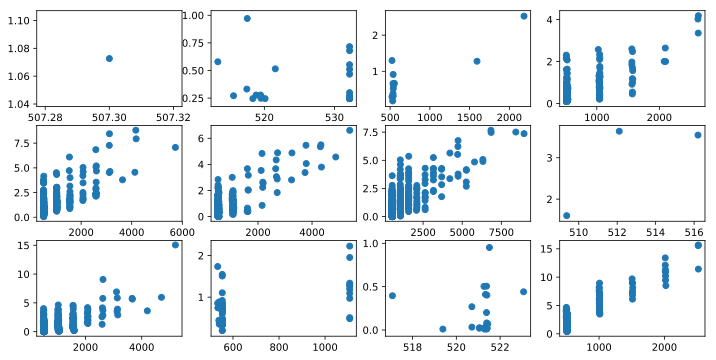

In [153]:
for idx, user in enumerate(test_users):
    plt.subplot(3, 4, idx+1)
    df = get_test_data(uid_keys[user])
    plt.scatter(x=df['time'], y=df['intensity'])
plt.show()

Ну в целом картина похожая для всех, у кого достаточное количество друзей и, соответственно, кандидатов в друзья.  
Добавим вычисление остальных фич в `get_test_data`

In [302]:
def get_data(uid):
    user_links = friends_matrix[uid_values[uid]].toarray().reshape(-1, )
    user_links_matrix = sparse.csr_matrix((user_links, ([i for i in range(size)], [i for i in range(size)])),
                                          shape=(size, size))
    user_links_matrix = friends_matrix * user_links_matrix
    
    # подсчитаем суммарную интенсивность
    user_matrix = user_links_matrix.multiply(intensity_sum_matrix) + user_links_matrix.multiply(intensity_sum_matrix[uid_values[uid]])
    user_intensity_vector = np.array([user_matrix[i].sum() for i in range(size)])
    
    # подсчитаем суммарное время
    user_matrix = user_links_matrix.multiply(time_average_matrix) + user_links_matrix.multiply(time_average_matrix[uid_values[uid]])
    user_time_vector = np.array([user_matrix[i].sum() for i in range(size)])
    
    # посчитаем коэффициенты Адамик/Адара
    user_matrix = get_adamic_matrix(uid)
    length = user_matrix.nonzero()[0].shape[0]
    j = user_matrix.nonzero()[0]
    k = user_matrix.nonzero()[1]
    for i in range(length):
            user_matrix[j[i], k[i]] = (1 / np.log(user_matrix[j[i], k[i]]))
    adamic_vector = np.array([user_matrix[i].sum() for i in range(size)])
    
    # посчитаем комбинацию коэффициента Адамик/Адара и времени с интенсивностью
    user_matrix = user_matrix.multiply(intensity_sum_matrix).multiply(time_average_matrix) + user_matrix.multiply(intensity_sum_matrix[uid_values[uid]]).multiply(time_average_matrix[uid_values[uid]])
    mod_adamic_vector = np.array([user_matrix[i].sum() for i in range(size)])
    
    # количество общих друзей
    common_friends_vector = np.array(common_friends_matrix[uid_values[uid]].toarray()[0])
    
    # коэффициент Жаккара
    jaccard_vector = np.array(common_friends_vector / (friends_count + friends_count[uid_values[uid]] - common_friends_vector))
    
    jaccard_vector[uid_values[uid]] = 0 
    jaccard_vector[friends_matrix[uid_values[uid]].nonzero()[1]] = 0
    common_friends_vector[uid_values[uid]] = 0 
    common_friends_vector[friends_matrix[uid_values[uid]].nonzero()[1]] = 0
    mod_adamic_vector[uid_values[uid]] = 0 
    mod_adamic_vector[friends_matrix[uid_values[uid]].nonzero()[1]] = 0  
    adamic_vector[uid_values[uid]] = 0 
    adamic_vector[friends_matrix[uid_values[uid]].nonzero()[1]] = 0  
    user_intensity_vector[uid_values[uid]] = 0 
    user_intensity_vector[friends_matrix[uid_values[uid]].nonzero()[1]] = 0
    user_time_vector[uid_values[uid]] = 0 
    user_time_vector[friends_matrix[uid_values[uid]].nonzero()[1]] = 0
    
    return pd.DataFrame({'uid': [uid_keys[i] for i in user_intensity_vector.nonzero()[0]],
                         'time': user_time_vector[user_time_vector.nonzero()[0]], 
                         'intensity': user_intensity_vector[user_intensity_vector.nonzero()[0]],
                         'adamic': adamic_vector[adamic_vector.nonzero()[0]], 
                         'mod_adamic': mod_adamic_vector[mod_adamic_vector.nonzero()[0]],
                         'friends_count': [friends_count[i] for i in user_intensity_vector.nonzero()[0]],
                         'common_friends': common_friends_vector[common_friends_vector.nonzero()[0]],
                         'jaccard': jaccard_vector[jaccard_vector.nonzero()[0]]})

In [299]:
%%time 
df = get_data(test_user)

CPU times: user 23.7 s, sys: 3.33 ms, total: 23.7 s
Wall time: 23.7 s


Все параметры считаются довольно долго, больше 20 секунд

In [396]:
df = get_data(test_user)

In [397]:
df.head()

,uid,time,intensity,adamic,mod_adamic,friends_count,common_friends,jaccard
0,9245023,1107.119761,1.532603,0.497648,105.616006,82,2,0.010989
1,3727103,518.396594,1.790787,0.219593,102.136447,65,1,0.006024
2,11213187,540.493117,0.001085,0.148540,0.042618,59,1,0.006250
3,15379343,1095.348378,1.249662,0.468995,71.974589,99,2,0.010050
4,3418036,539.463411,0.013368,0.197281,0.724275,13,1,0.008772


Применим KMeans к новым данным и сравним с предыдущими результатами

In [486]:
def get_predict(df):
    num_of_users = 20
    # если у пользователя мало кандидатов в друзья, можно рекомендовать их всех и не кластеризовать
    # или рекомендовать знаменитостей
    if df.shape[0] < 20:
        return np.array(df['uid'].values)
    elif (df.shape[0] > 20) & (df.shape[0] < 50):
        num_of_clusters = 3
    elif (df.shape[0] > 50) & (df.shape[0] < 100):
        num_of_clusters = 5
    elif (df.shape[0] > 100) & (df.shape[0] < 500):
        num_of_clusters = 7
    else:
        num_of_clusters = 10
        
    kmeans = KMeans(n_clusters=num_of_clusters)
    kmeans.fit(df.drop('uid', axis=1))
    
    # вычислим самые лучшие кластеры (просто проссумировав значения признаков в центре кластера)
    clusters = Counter()
    for idx, cluster in enumerate(kmeans.cluster_centers_):
        res = 0
        for i in cluster:
            res += i
            clusters[idx] = res
    clusters.most_common()
    
    # и вернем топ-20 самых релевантных
    res = []
    clk = 0
    for cluster in clusters.most_common():
        for user in np.argwhere(kmeans.labels_ == cluster[0]).reshape(-1):
            res.append(df.iloc[user][0])
            clk += 1
            if clk == num_of_users:
                break
        if clk == num_of_users:
            break
            
    return np.array(res, dtype=int)

In [472]:
get_predict(df) == indexes

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

Новая модель предсказала точно тех же пользователей, что и предыдущая.  
Это не очень здорово, получается, что добавленные признаки не играют никакой роли.  

Очевидны недостатки данного подхода:  
 - непонятно как оценить результат (а, следовательно, непонятно как его улучшить);  
 - не учитвает релевантность выдачи внутри кластера;  
 
Можно провести тестирование, посмотреть на изменение реальное продуктовой метрики, но если оно не устраивает, неясно как изменить модель в лучшую сторону.  

Попробую разметить тренировочный датасет и обучить обычный классификатор.  
Размечать буду следующим образом:  
 - возьму всех друзей пользователя, это будут пользователи "1";  
 - возьму вдвое большее количество случайных кадидатов в друзья пользователя, это будут пользователи "0";
 - обучу классификатор на этих данных;   
 - сделаю предикт, возьму 20 лучших.  
 
Есть явный недостаток - очень маленькая обучающая выборка, в которую к тому же случайным образом могут попасть люди, которых хотелось бы порекомендовать пользователю.  
Однако, такой подход будет лучше решения через формулу, т.к. учтет и другие признаки, и лучше решения с кластеризацией, т.к. улучшится релевантность выдачи.  

Слегка изменим `get_data`, чтобы получать тренировочный и тестовый датасеты

In [1027]:
def get_data(uid):
    user_links = friends_matrix[uid_values[uid]].toarray().reshape(-1, )
    user_links_matrix = sparse.csr_matrix((user_links, ([i for i in range(size)], [i for i in range(size)])),
                                          shape=(size, size))
    user_links_matrix = friends_matrix * user_links_matrix
    
    # подсчитаем суммарную интенсивность
    user_matrix = user_links_matrix.multiply(intensity_sum_matrix) + user_links_matrix.multiply(intensity_sum_matrix[uid_values[uid]])
    user_intensity_vector = np.array([user_matrix[i].sum() for i in range(size)])
    
    # подсчитаем суммарное время
    user_matrix = user_links_matrix.multiply(time_average_matrix) + user_links_matrix.multiply(time_average_matrix[uid_values[uid]])
    user_time_vector = np.array([user_matrix[i].sum() for i in range(size)])
    
    # посчитаем коэффициенты Адамик/Адара
    user_matrix = get_adamic_matrix(uid)
    length = user_matrix.nonzero()[0].shape[0]
    j = user_matrix.nonzero()[0]
    k = user_matrix.nonzero()[1]
    for i in range(length):
            user_matrix[j[i], k[i]] = (1 / np.log(user_matrix[j[i], k[i]]))
    adamic_vector = np.array([user_matrix[i].sum() for i in range(size)])
    
    # посчитаем комбинацию коэффициента Адамик/Адара и времени с интенсивностью
    user_matrix = user_matrix.multiply(intensity_sum_matrix).multiply(time_average_matrix) + user_matrix.multiply(intensity_sum_matrix[uid_values[uid]]).multiply(time_average_matrix[uid_values[uid]])
    mod_adamic_vector = np.array([user_matrix[i].sum() for i in range(size)])
    
    # количество общих друзей
    common_friends_vector = np.array(common_friends_matrix[uid_values[uid]].toarray()[0])
    
    # коэффициент Жаккара
    jaccard_vector = np.array(common_friends_vector / (friends_count + friends_count[uid_values[uid]] - common_friends_vector))
    
    # добавим информацию о друзьях и потенциальных друзьях
    jaccard_vector[uid_values[uid]] = 0 
    jaccard_train_vector = jaccard_vector[friends_matrix[uid_values[uid]].nonzero()[1]]
    jaccard_vector[friends_matrix[uid_values[uid]].nonzero()[1]] = 0
    common_friends_vector[uid_values[uid]] = 0 
    common_friends_train_vector = common_friends_vector[friends_matrix[uid_values[uid]].nonzero()[1]]
    common_friends_vector[friends_matrix[uid_values[uid]].nonzero()[1]] = 0
    mod_adamic_vector[uid_values[uid]] = 0 
    mod_adamic_train_vector = mod_adamic_vector[friends_matrix[uid_values[uid]].nonzero()[1]]
    mod_adamic_vector[friends_matrix[uid_values[uid]].nonzero()[1]] = 0  
    adamic_vector[uid_values[uid]] = 0 
    adamic_train_vector = adamic_vector[friends_matrix[uid_values[uid]].nonzero()[1]]
    adamic_vector[friends_matrix[uid_values[uid]].nonzero()[1]] = 0  
    user_intensity_vector[uid_values[uid]] = 0 
    user_intensity_train_vector = user_intensity_vector[friends_matrix[uid_values[uid]].nonzero()[1]]
    user_intensity_vector[friends_matrix[uid_values[uid]].nonzero()[1]] = 0
    user_time_vector[uid_values[uid]] = 0 
    user_time_train_vector = user_time_vector[friends_matrix[uid_values[uid]].nonzero()[1]]
    user_time_vector[friends_matrix[uid_values[uid]].nonzero()[1]] = 0
    
    test = pd.DataFrame({'uid': [uid_keys[i] for i in user_intensity_vector.nonzero()[0]],
                         'time': user_time_vector[user_time_vector.nonzero()[0]], 
                         'intensity': user_intensity_vector[user_intensity_vector.nonzero()[0]],
                         'adamic': adamic_vector[adamic_vector.nonzero()[0]], 
                         'mod_adamic': mod_adamic_vector[mod_adamic_vector.nonzero()[0]],
                         'friends_count': [friends_count[i] for i in user_intensity_vector.nonzero()[0]],
                         'common_friends': common_friends_vector[common_friends_vector.nonzero()[0]],
                         'jaccard': jaccard_vector[jaccard_vector.nonzero()[0]]})
    train = pd.DataFrame({'time': user_time_train_vector, 
                         'intensity': user_intensity_train_vector,
                         'adamic': adamic_train_vector, 
                         'mod_adamic': mod_adamic_train_vector,
                         'friends_count': [friends_count[i] for i in friends_matrix[uid_values[test_user]].nonzero()[1]],
                         'common_friends': common_friends_train_vector,
                         'jaccard': jaccard_train_vector, 
                         'target': 1})
    
    to_train = test.sample(3*train.shape[0]).drop('uid', axis=1)
    to_train['target'] = 0
    train = train.append(to_train)
    test.drop(index=to_train.index, inplace=True)
    
    return test, train

In [850]:
test, train = get_data(test_user)

In [852]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [884]:
X_train, X_holdout, y_train, y_holdout = train_test_split(train.drop('target', axis=1), train['target'].values, test_size=.25)
rf = RandomForestClassifier(n_estimators=1000, max_features=2, oob_score=True, max_depth=50, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

Взглянем на важность признаков

In [885]:
Counter(dict(zip(X_train.columns, rf.feature_importances_))).most_common()

[('adamic', 0.19407756402891968),
 ('mod_adamic', 0.1764032689779044),
 ('time', 0.16818372510842897),
 ('jaccard', 0.1652115707863702),
 ('intensity', 0.1573171302167937),
 ('common_friends', 0.08148819916107887),
 ('friends_count', 0.05731854172050451)]

In [886]:
roc_auc_score(y_holdout, rf.predict_proba(X_holdout)[:, 1])

0.9777373920945025

In [887]:
pred = rf.predict_proba(test.drop('uid', axis=1))

In [888]:
rf_top = Counter(dict(zip(test['uid'].values, pred[:, 1]))).most_common(20)

In [889]:
rf_top

[(6718597, 1.0),
 (10408761, 1.0),
 (6781049, 1.0),
 (8207204, 1.0),
 (5967021, 1.0),
 (12514760, 1.0),
 (2720992, 1.0),
 (10181839, 1.0),
 (8408875, 0.999),
 (903943, 0.999),
 (6941391, 0.999),
 (3697025, 0.998),
 (1725125, 0.998),
 (9157706, 0.996),
 (13844609, 0.994),
 (86527, 0.992),
 (6316803, 0.987),
 (6577559, 0.984),
 (8747060, 0.982),
 (14388511, 0.981)]

Сравним результаты работы данного подхода и  кластеризации

In [896]:
list(zip(np.array(rf_top, dtype=int).transpose()[0], np.array(top_friends, dtype=int).transpose()[0]))

[(6718597, 9157706),
 (10408761, 6718597),
 (6781049, 86527),
 (8207204, 12514760),
 (5967021, 10408761),
 (12514760, 1725125),
 (2720992, 16362876),
 (10181839, 6577559),
 (8408875, 13844609),
 (903943, 903943),
 (6941391, 12167488),
 (3697025, 6781049),
 (1725125, 8207204),
 (9157706, 8408875),
 (13844609, 2720992),
 (86527, 6316803),
 (6316803, 10181839),
 (6577559, 5967021),
 (8747060, 6941391),
 (14388511, 3027020)]

Видно, что алгоритмы выдают очень похожие результаты.

Проблему с выборкой для случайного леса можно решить, включив в нее всех друзей всех пользователей и такое же количество случайных кандидатов среди всех пользователей.  
В такой реализации случайный лес будет лишен недостатка данного решения, и лишен недостатков предыдущих решений. Ответы будут релевантны, есть метрика, которую можно улучшать, данных будет предостаточно, будут учтены все признаки.  

In [1107]:
def get_train_data(uid):
    user_links = friends_matrix[uid_values[uid]].toarray().reshape(-1, )
    user_links_matrix = sparse.csr_matrix((user_links, ([i for i in range(size)], [i for i in range(size)])),
                                          shape=(size, size))
    user_links_matrix = friends_matrix * user_links_matrix
    
    # подсчитаем суммарную интенсивность
    user_matrix = user_links_matrix.multiply(intensity_sum_matrix) + user_links_matrix.multiply(intensity_sum_matrix[uid_values[uid]])
    user_intensity_vector = np.array([user_matrix[i].sum() for i in range(size)])
    
    # подсчитаем суммарное время
    user_matrix = user_links_matrix.multiply(time_average_matrix) + user_links_matrix.multiply(time_average_matrix[uid_values[uid]])
    user_time_vector = np.array([user_matrix[i].sum() for i in range(size)])
    
    # посчитаем коэффициенты Адамик/Адара
    user_matrix = get_adamic_matrix(uid)
    length = user_matrix.nonzero()[0].shape[0]
    j = user_matrix.nonzero()[0]
    k = user_matrix.nonzero()[1]
    for i in range(length):
            user_matrix[j[i], k[i]] = (1 / np.log(user_matrix[j[i], k[i]]))
    adamic_vector = np.array([user_matrix[i].sum() for i in range(size)])
    
    # посчитаем комбинацию коэффициента Адамик/Адара и времени с интенсивностью
    user_matrix = user_matrix.multiply(intensity_sum_matrix).multiply(time_average_matrix) + user_matrix.multiply(intensity_sum_matrix[uid_values[uid]]).multiply(time_average_matrix[uid_values[uid]])
    mod_adamic_vector = np.array([user_matrix[i].sum() for i in range(size)])
    
    # количество общих друзей
    common_friends_vector = np.array(common_friends_matrix[uid_values[uid]].toarray()[0])
    
    # коэффициент Жаккара
    jaccard_vector = np.array(common_friends_vector / (friends_count + friends_count[uid_values[uid]] - common_friends_vector))
    
    # добавим информацию о друзьях и потенциальных друзьях
    jaccard_vector[uid_values[uid]] = 0 
    jaccard_train_vector = jaccard_vector[friends_matrix[uid_values[uid]].nonzero()[1]]
    jaccard_vector[friends_matrix[uid_values[uid]].nonzero()[1]] = 0
    common_friends_vector[uid_values[uid]] = 0 
    common_friends_train_vector = common_friends_vector[friends_matrix[uid_values[uid]].nonzero()[1]]
    common_friends_vector[friends_matrix[uid_values[uid]].nonzero()[1]] = 0
    mod_adamic_vector[uid_values[uid]] = 0 
    mod_adamic_train_vector = mod_adamic_vector[friends_matrix[uid_values[uid]].nonzero()[1]]
    mod_adamic_vector[friends_matrix[uid_values[uid]].nonzero()[1]] = 0  
    adamic_vector[uid_values[uid]] = 0 
    adamic_train_vector = adamic_vector[friends_matrix[uid_values[uid]].nonzero()[1]]
    adamic_vector[friends_matrix[uid_values[uid]].nonzero()[1]] = 0  
    user_intensity_vector[uid_values[uid]] = 0 
    user_intensity_train_vector = user_intensity_vector[friends_matrix[uid_values[uid]].nonzero()[1]]
    user_intensity_vector[friends_matrix[uid_values[uid]].nonzero()[1]] = 0
    user_time_vector[uid_values[uid]] = 0 
    user_time_train_vector = user_time_vector[friends_matrix[uid_values[uid]].nonzero()[1]]
    user_time_vector[friends_matrix[uid_values[uid]].nonzero()[1]] = 0
    
    common_uids = common_friends_vector.nonzero()[0]
    
    test = pd.DataFrame({'time': user_time_vector[common_uids], 
                         'intensity': user_intensity_vector[common_uids],
                         'adamic': adamic_vector[common_uids], 
                         'mod_adamic': mod_adamic_vector[common_uids],
                         'common_friends': common_friends_vector[common_uids],
                         'jaccard': jaccard_vector[common_uids]})
     
    train = pd.DataFrame({'time': user_time_train_vector,
                          'intensity': user_intensity_train_vector,
                          'adamic': adamic_train_vector, 
                          'mod_adamic': mod_adamic_train_vector,
                          'common_friends': common_friends_train_vector,
                          'jaccard': jaccard_train_vector, 
                          'target': 1})
    
    to_train = test.sample(2 * train.shape[0])
    to_train['target'] = 0
    train = train.append(to_train)
    
    return train

Ну по всем пользователям я вечно считать буду, возьму небольшое число пользователей с большим (выше среднего) количество друзей

In [1109]:
train = pd.DataFrame()
uids_train = users[(users['friends_count'] > 80) & (users['friends_count'] < 90)]['uid'].values

In [1110]:
for uid in tqdm(uids_train):
    train = train.append(get_train_data(uid))

In [1111]:
# сохраню себе на всякий случай, чтобы 2.5 часа потом не пересчитывать
train.to_csv('vk_train_1.csv')

In [1114]:
test, _ = get_data(test_user)

In [1196]:
X_train, X_holdout, y_train, y_holdout = train_test_split(train.drop('target', axis=1), train['target'].values, test_size=.25)
rf = RandomForestClassifier(n_estimators=1000, max_features=2, max_depth=10, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [1197]:
Counter(dict(zip(X_train.columns, rf.feature_importances_))).most_common()

[('adamic', 0.3244129515384902),
 ('jaccard', 0.23631708974844978),
 ('time', 0.2165941939000764),
 ('common_friends', 0.14516671585850996),
 ('mod_adamic', 0.06356571394309322),
 ('intensity', 0.013943335011380793)]

In [1198]:
roc_auc_score(y_holdout, rf.predict_proba(X_holdout)[:, 1])

0.9482338729585355

In [1204]:
pred = rf.predict_proba(test.drop(['uid', 'friends_count'], axis=1))
rf_top = Counter(dict(zip(test['uid'].values, pred[:, 1]))).most_common(5)

In [1205]:
rf_top

[(9157706, 0.9968012848172731),
 (6718597, 0.9910412950632638),
 (6941391, 0.9738543323022169),
 (12514760, 0.9723562361225218),
 (10181839, 0.9651905466039643)]

In [1207]:
list(zip(np.array(rf_top, dtype=int).transpose()[0], np.array(top_friends, dtype=int).transpose()[0], indexes))

[(9157706, 9157706, 6718597),
 (6718597, 6718597, 9157706),
 (6941391, 86527, 86527),
 (12514760, 12514760, 12514760),
 (10181839, 10408761, 10181839)]

Видимо, пользователь 86527 попал в тренировочную выборку и был размечен как 0, повезло то как.

В целом, на мой взгляд неплохо. 
В отличии от решения с формулой, модель учитывает больше признаков, есть метрика, по которой можно оценить модель.  
В будущем можно было бы добавить еще каких-нибудь фичей, может, поэксперементировать с весами признаков. Попробовать другую модель. Добавить данных. Решение с помощью ML довольно гибкое, его можно поти бесконечно улучшать.  
Однако, я вижу абсолютно идентичные ответы (не считая потерянного 86527), поэтому по результатам моей работы нет смысла в утилите использовать тяжеловесный ML с долгим рассчетом признаков и построением тренировочного датасета.  
Я просто использую быстрое и точное решение черех эмпирическую формулу. К сожалению, у меня не вышло как-то улучшить этот подход с помощью ML. Был бы очень рад возможности узнать как это все работает в реальных проектах в проде, это оказалось очень интересным.  
Спасибо за внимание!